In [ ]:
import sys
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from accelerate import Accelerator
from accelerate.utils import set_seed, ProjectConfiguration, LoggerType
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
# Add project root to sys.path
project_root = os.path.abspath("/workspace/meteolibre_model/")
sys.path.insert(0, project_root)


from meteolibre_model.dataset.dataset import MeteoLibreMapDataset
from meteolibre_model.diffusion.blurring_diffusion import trainer_step, full_image_generation
from meteolibre_model.models.dc_3dunet_film import UNet_DCAE_3D


In [2]:
# Initialize dataset
dataset = MeteoLibreMapDataset(
    localrepo="/workspace/data/data",  # Replace with your dataset path
    cache_size=8,
    seed=42,
)

In [93]:
dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=1, #os.cpu_count() // 2,  # Use half the available CPUs
        pin_memory=True,
    )



In [94]:
for batch in dataloader:
    break

In [109]:
import torch

import numpy as np
import scipy.fft
from PIL import Image


from meteolibre_model.diffusion.utils import MEAN_CHANNEL, STD_CHANNEL



# The model expects (BATCH, NB_CHANNEL, NB_TEMPORAL, H, W), so permute dimensions
batch_data = batch["patch_data"].permute(0, 2, 1, 3, 4)

# normalize using MEAN and STD
batch_data = (
    batch_data.to("cuda") - MEAN_CHANNEL.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to("cuda")
) / STD_CHANNEL.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to("cuda") * 4

# garde fou
batch_data = batch_data.clamp(-7, 7)

x_context = batch_data[:, :, :4]  # Shape: (BATCH, NB_CHANNEL, 4, H, W)
x_target = batch_data[:, :, 4:]  # This is x_0, shape: (BATCH, NB_CHANNEL, 2, H, W)


# 3. Create noisy target by applying blurring diffusion forward process
x_t_batch = torch.zeros_like(x_target)

tensor(0.6548, device='cuda:0')
tensor(0.7215, device='cuda:0')
tensor(0.7607, device='cuda:0')
tensor(0.7984, device='cuda:0')
tensor(0.8236, device='cuda:0')
tensor(0.8257, device='cuda:0')


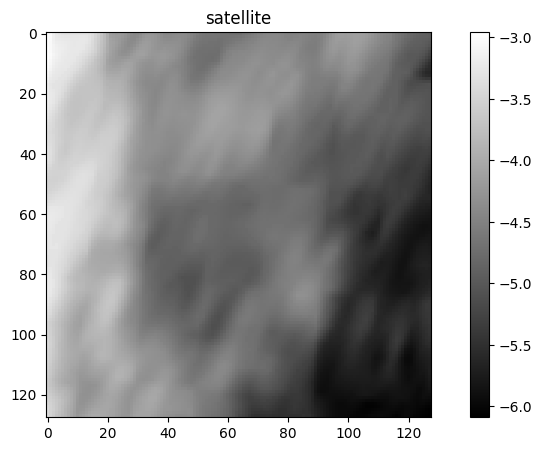

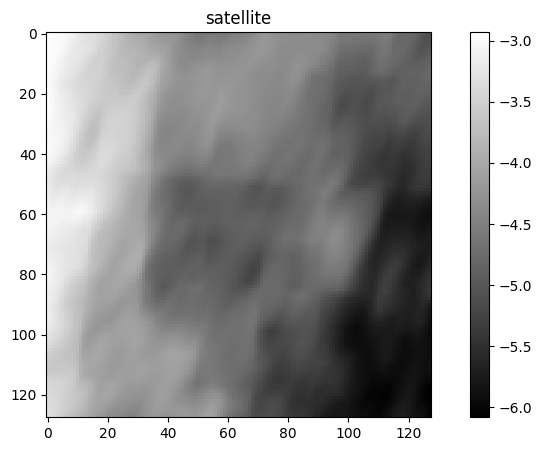

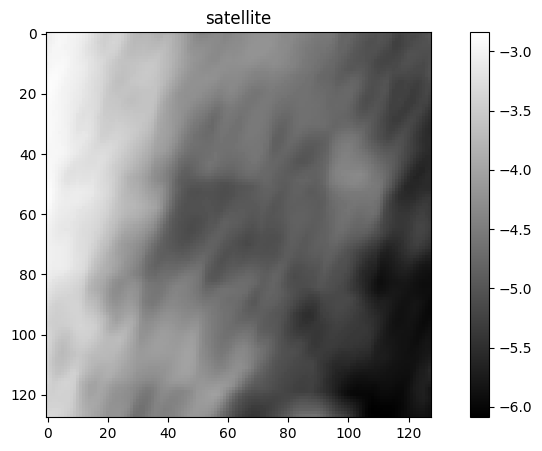

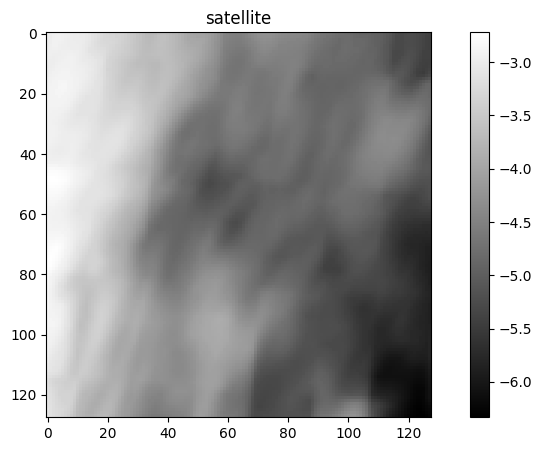

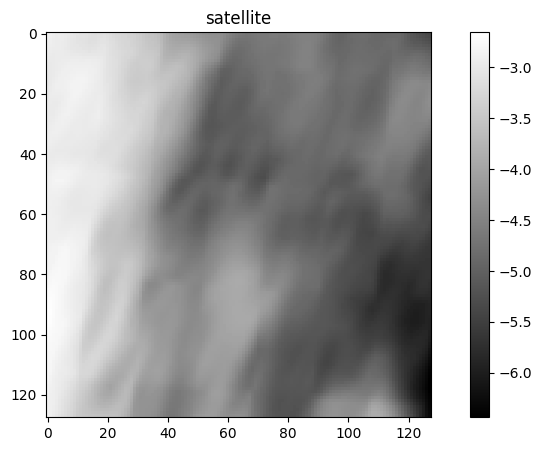

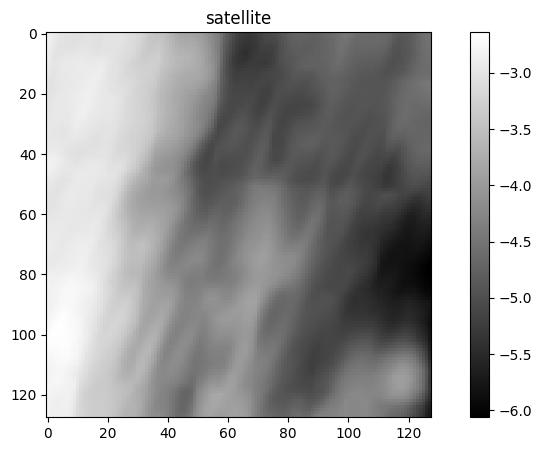

In [110]:

for i in range(6):
    sat = batch_data[0, -2, i, :, :]
    print(batch_data[0, -2, i, :, :].std())
    plt.figure(figsize=(10, 5))
    plt.imshow(sat.cpu().numpy(), cmap='gray')
    plt.title('satellite')
    plt.colorbar()

In [113]:
from meteolibre_model.diffusion.blurring_diffusion import get_blurring_diffusion_schedules

# 1. Generate random timesteps for the batch
t_batch = torch.linspace(0, 1., 32)

# 2. Generate noise
noise = torch.randn_like(x_target)
# -- Parameters --
BLUR_SIGMA_MAX = 1.

# Loop over the batch to create x_t for each sample
# This is done one-by-one because get_blurring_diffusion_schedules is not vectorized
for i in range(x_target.size(0)):
    x_0_sample = x_target[i : i + 1]
    t_sample = t_batch[i].item()
    noise_sample = noise[i : i + 1]

    h, w = x_0_sample.shape[-2], x_0_sample.shape[-1]

    # Get schedules for the current timestep
    alpha_t_vec, sigma_t_scalar = get_blurring_diffusion_schedules(
        t_sample, h, w, BLUR_SIGMA_MAX
    )

    # Convert numpy schedules to torch tensors
    alpha_t_t = torch.from_numpy(alpha_t_vec).to(
        x_target.device, dtype=x_target.dtype
    )
    sigma_t_t = torch.tensor(
        sigma_t_scalar, device=x_target.device, dtype=x_target.dtype
    )

    # Move to numpy for DCT
    x_0_sample_np = x_0_sample.cpu().numpy()

    # Apply DCT
    x_0_freq = scipy.fft.dctn(x_0_sample_np, norm="ortho", axes=(-2, -1))

    # Apply blurring in frequency domain
    blurred_signal_freq = alpha_t_t.cpu().numpy() * x_0_freq

    # Apply IDCT
    blurred_signal_np = scipy.fft.idctn(
        blurred_signal_freq, norm="ortho", axes=(-2, -1)
    )

    blurred_signal = torch.from_numpy(blurred_signal_np).to(
        x_target.device, dtype=x_target.dtype
    )

    # Add noise in pixel space to create x_t
    x_t_sample = blurred_signal + sigma_t_t * noise_sample
    x_t_batch[i] = x_t_sample

/tmp/ipykernel_38288/3533674126.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


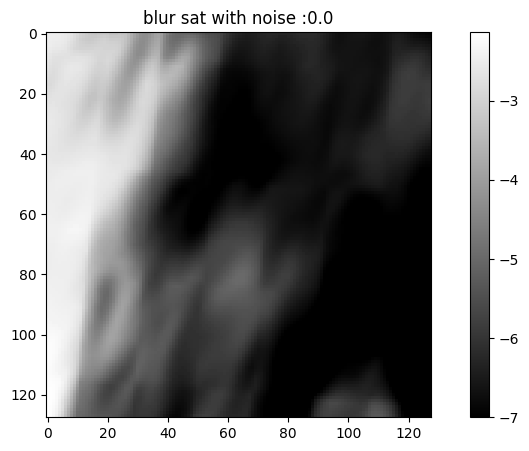

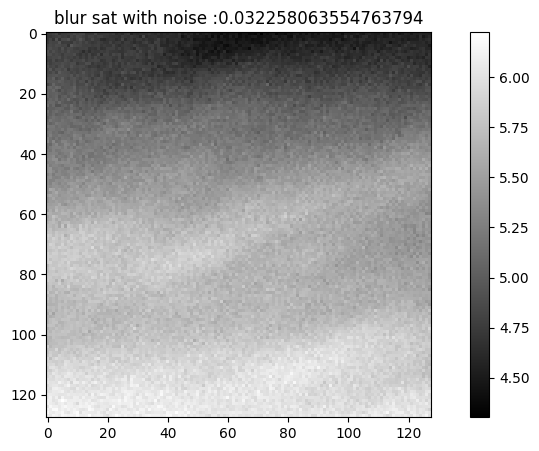

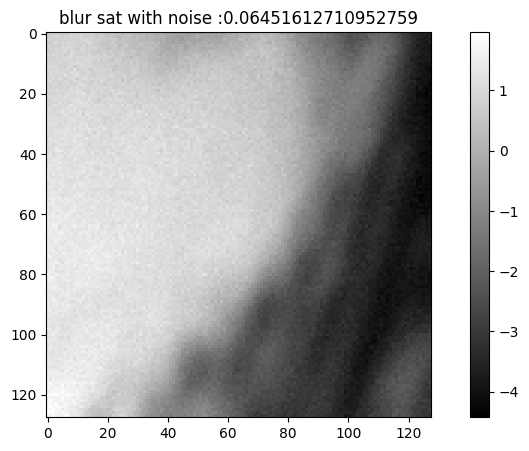

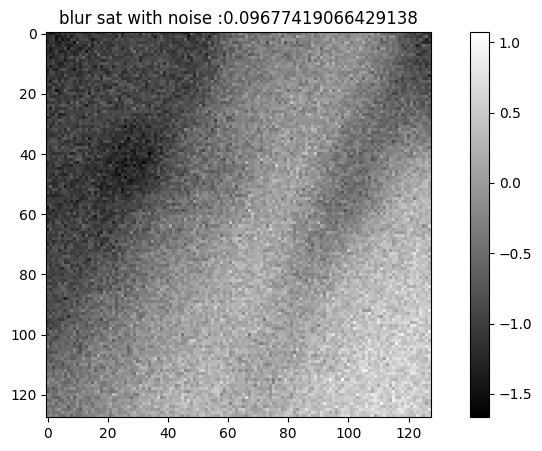

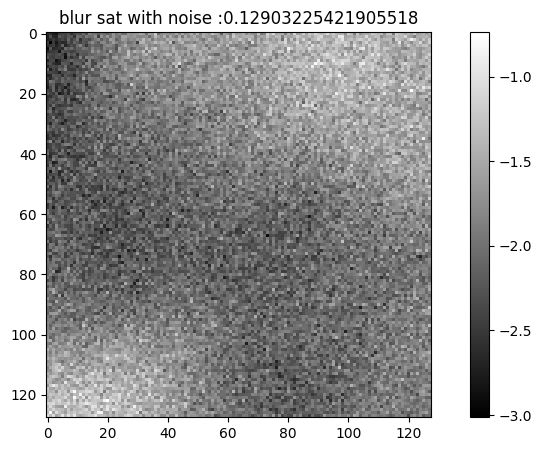

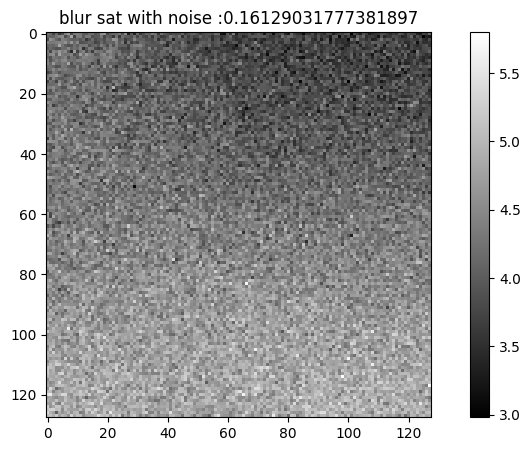

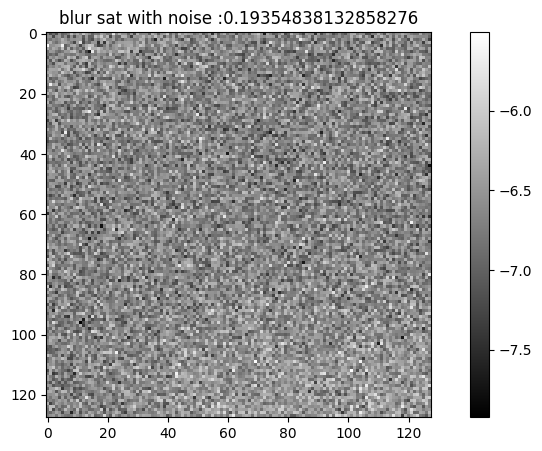

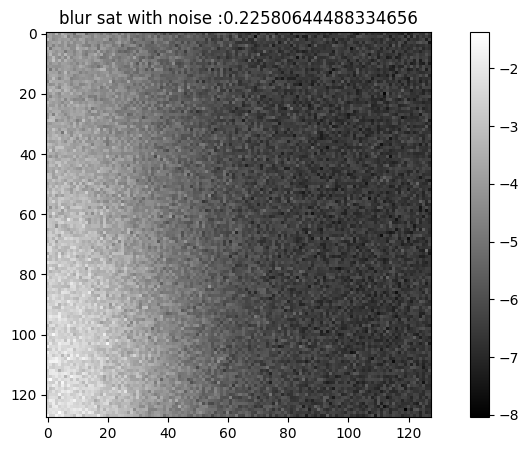

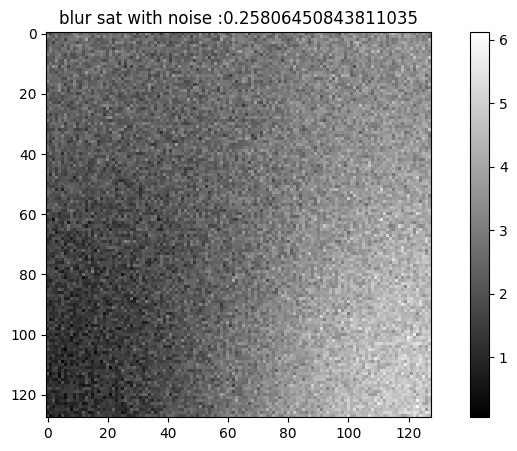

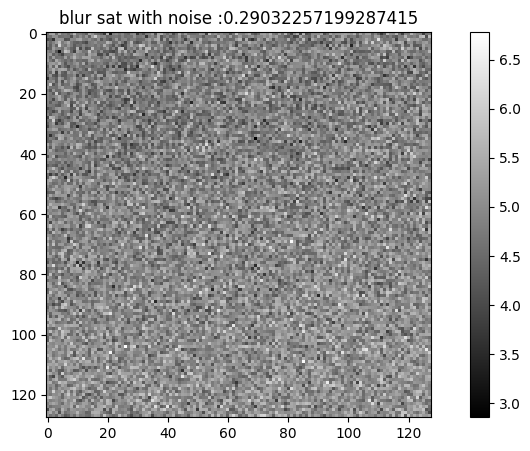

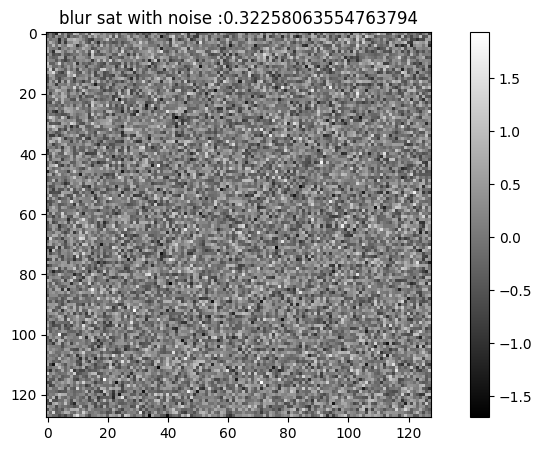

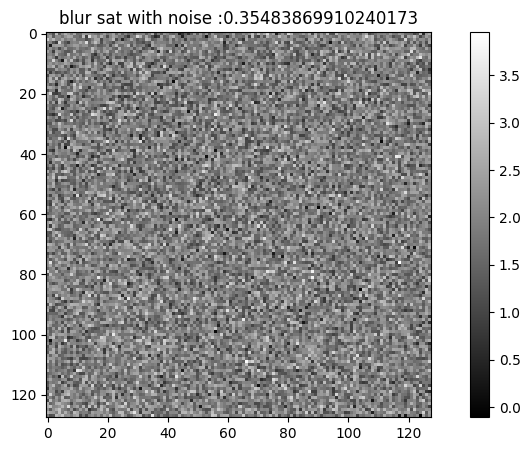

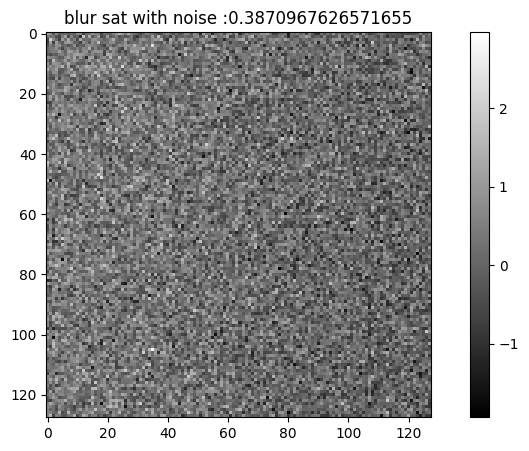

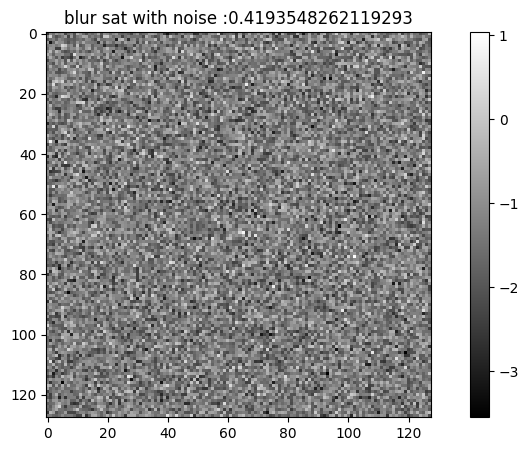

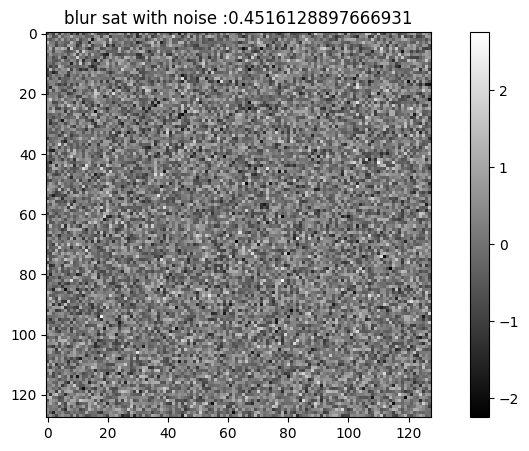

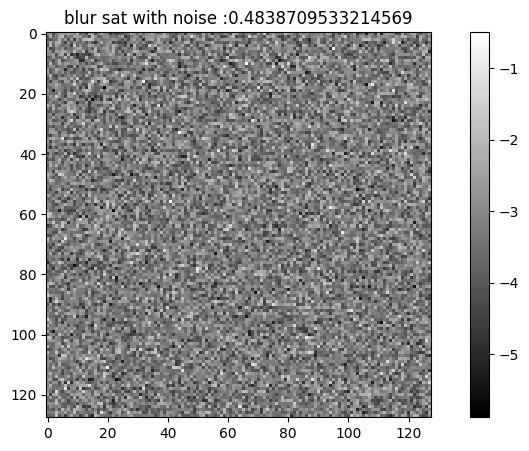

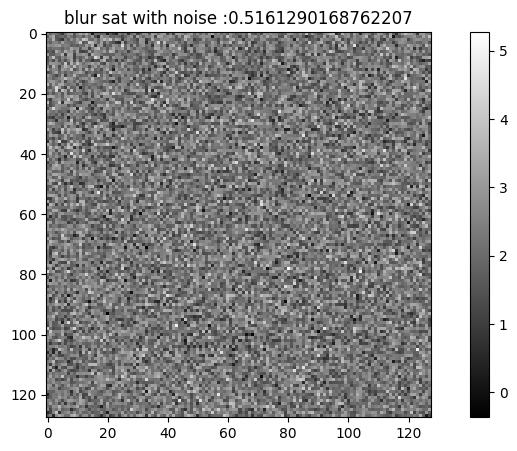

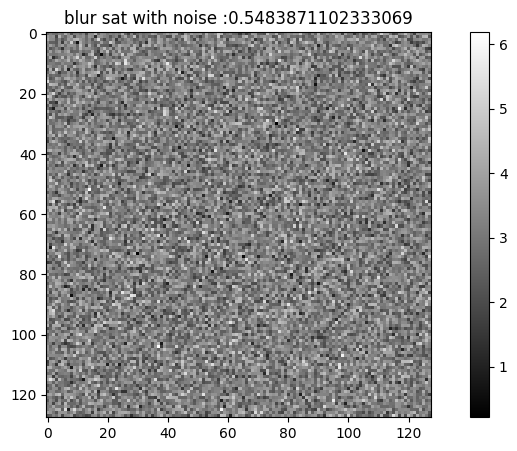

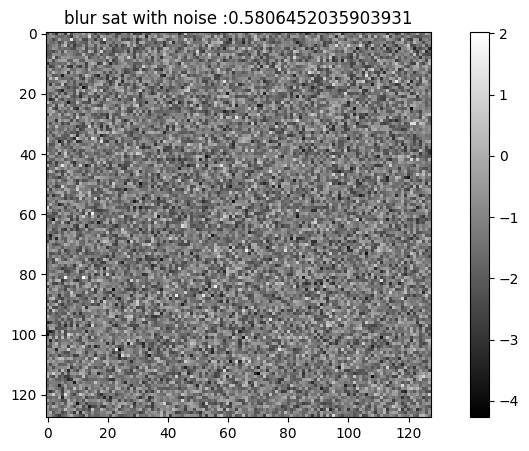

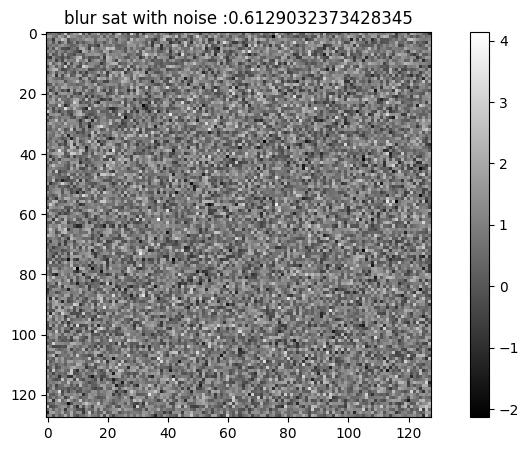

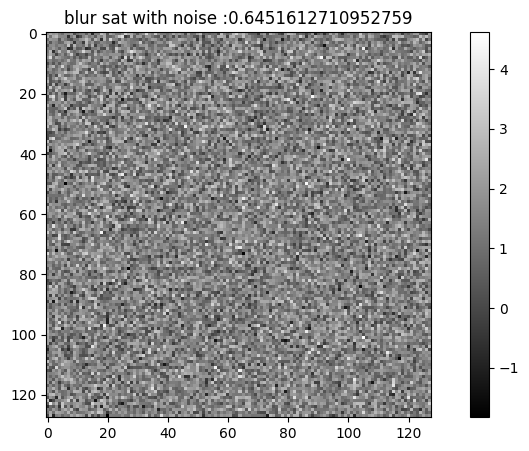

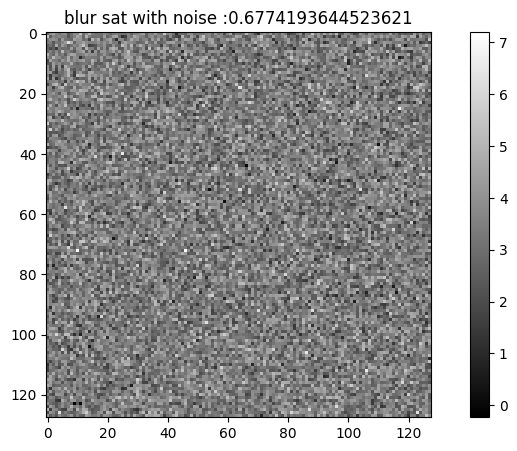

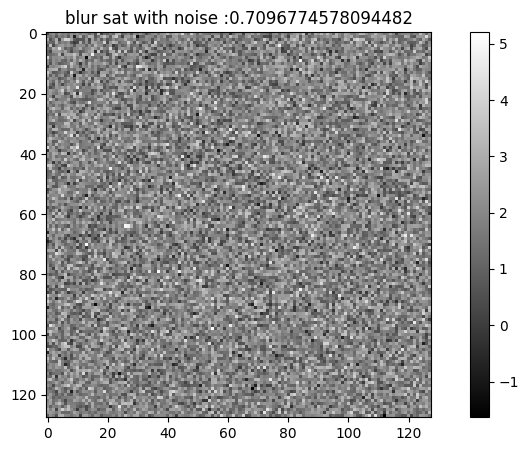

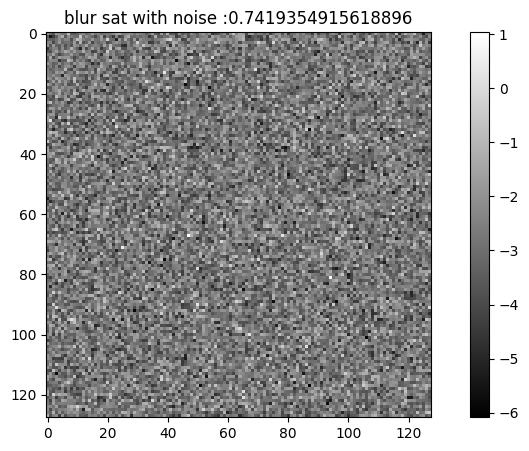

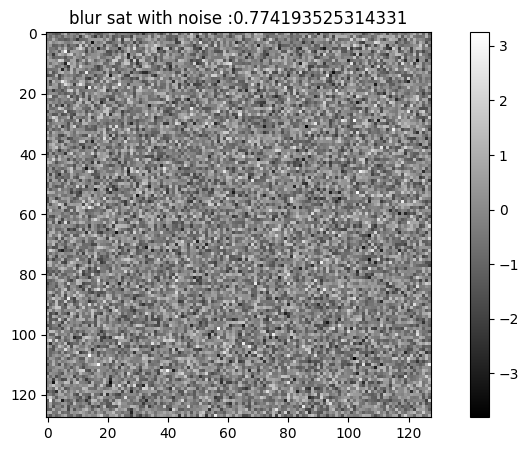

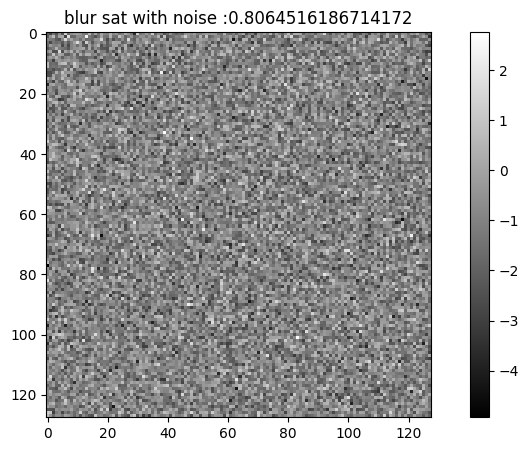

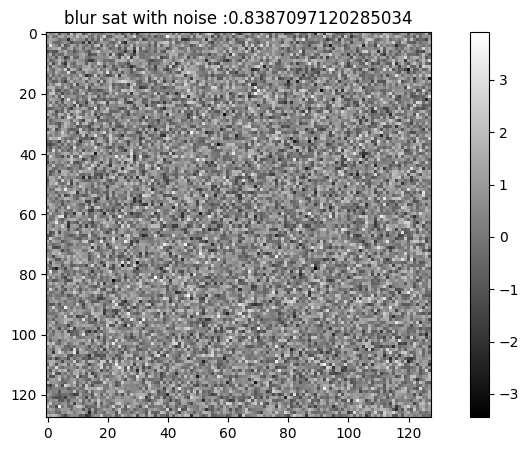

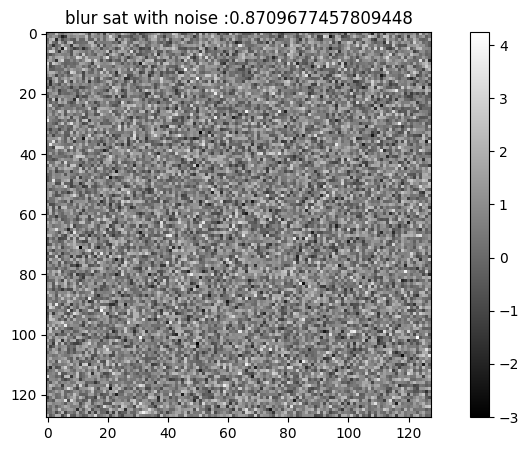

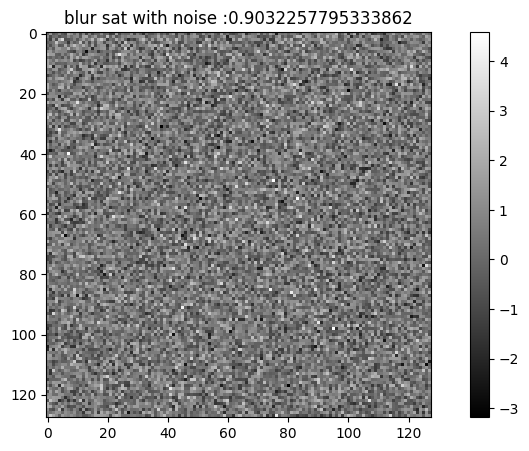

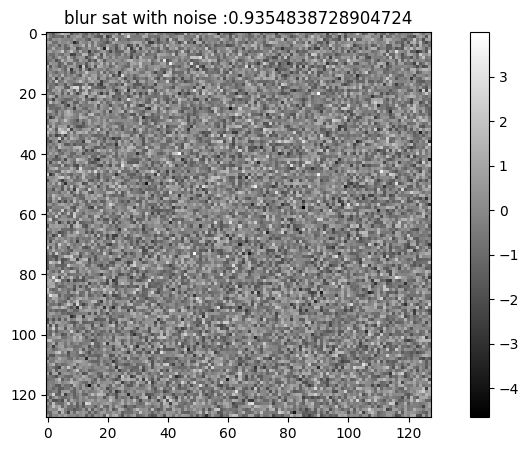

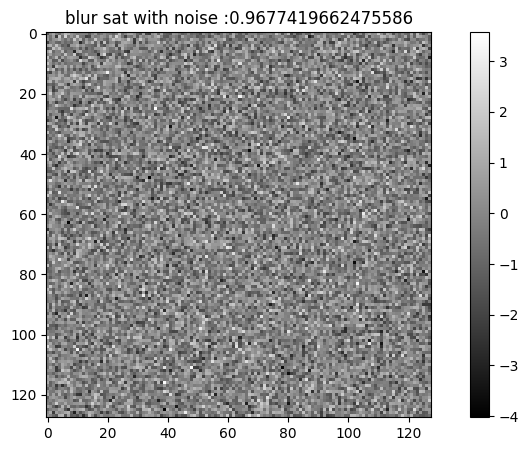

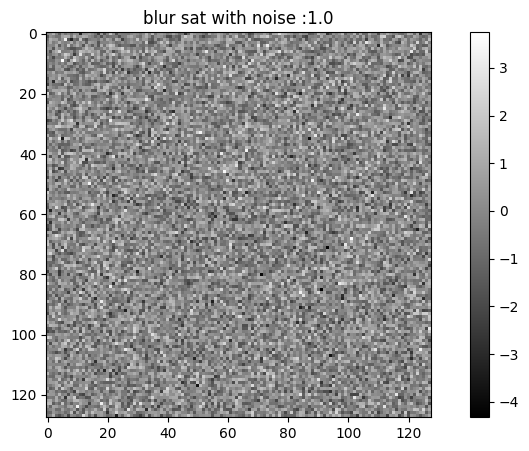

In [114]:


for t in range(32):

    plt.figure(figsize=(10, 5))
    plt.imshow(x_t_batch[t, -1, 0, :, :].cpu().numpy(), cmap='gray')

    plt.title('blur sat with noise :' + str(t_batch[t].item()))
    plt.colorbar()

In [20]:
x_t_batch.shape

torch.Size([8, 12, 2, 128, 128])